In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


The solve_ivp method uses an adptive step size based on the relative and absolute tolerance fixed, so to impose a fixed step size I fix the max_step value and disable atol and rtol by setting they value to large constants.

In [4]:
def two_body_ODE(t ,y, GM):
  #Dividing y in positions and velocities
  r1, r2  = y[0:2], y[2:4]  #The first four variables are positions
  v1, v2 = y[4:6], y[6:8]  #The next four are velocities
  #Calculating the accelerations
  r_12 = r2-r1
  r3 = np.linalg.norm(r_12)**3
  #With concatenate I concatenate vectors side by side to get the state vector
  return np.array(np.concatenate((v1, v2, GM/r3*r_12, -GM/r3*r_12), axis=None))


In [ ]:
def Euler(f, y0, t_span, step=0.1, args=None):
  t0, tf = t_span[0], t_span[1]
  Y = [y0]
  T = [t0]
  t= t0
  
  while t < tf:
    
    y = np.array(Y[-1])
    y = y + step*f(t,y, *args)
    t  = t + step

    Y.append(y)
    T.append(t)

  return T, np.array(Y).T


In [ ]:
GM = 1.0
m = 1.5e10
#Initial positions and velocities 
r1 = np.array([-10,-0.5])
r2 = np.array([10, 0.5])
v1 = np.array([1,0])
v2 = np.array([-1,0])

t0, tf = 0, 20

# Getting the modified state vector
y0 = np.concatenate((r1, r2, v1, v2), axis=None)


T1, Y1 = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=0.5, args=(GM,))
T2, Y2 = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=0.1, args=(GM,))


In [ ]:
def E(y):
  r1, r2  = y[0:2], y[2:4]  
  v1, v2 = y[4:6], y[6:8] 
  return 0.5*m*np.sum(v1**2, axis=0)+0.5*m*np.sum(v2**2, axis=0)-GM*m/np.linalg.norm(r1-r2, axis=0)


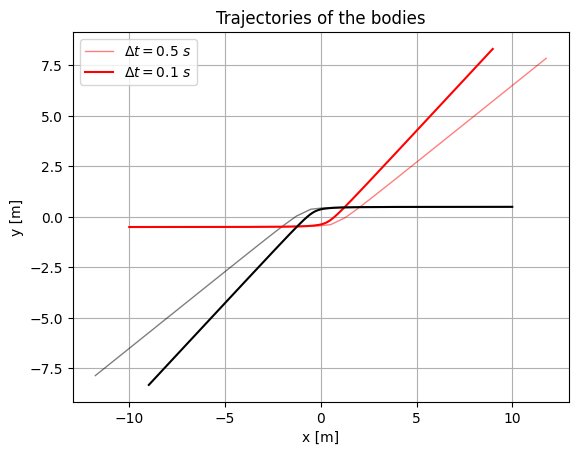

In [ ]:
E1 = E(Y1)
x1, y1, x2, y2, = Y1[0], Y1[1], Y1[2], Y1[3]

plt.plot(x1,y1,'r', lw=1, alpha=0.5, label =f'$\Delta t = 0.5$ $s$')
plt.plot(x2,y2,'k', lw=1, alpha=0.5)

E2 = E(Y2)
x1, y1, x2, y2, = Y2[0], Y2[1], Y2[2], Y2[3]
plt.plot(x1,y1,'r', label =f'$\Delta t = 0.1$ $s$')
plt.plot(x2,y2,'k')

plt.title('Trajectories of the bodies')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()
plt.grid()


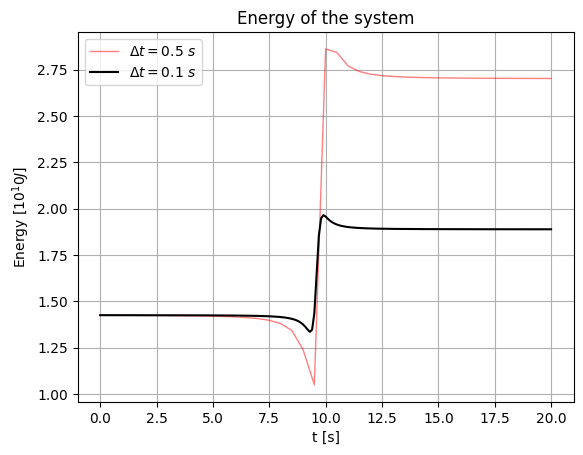

In [ ]:
energy_unit = 1e10

plt.title('Energy of the system')
plt.grid()
plt.plot(T1,E1/energy_unit, 'r', lw=1, alpha=0.5, label =f'$\Delta t = 0.5$ $s$')
plt.plot(T2,E2/energy_unit, 'k',label =f'$\Delta t = 0.1$ $s$')
plt.xlabel('t [s]')
plt.ylabel(f'Energy [$10^{10}J$]')
plt.legend()


## Investigating the relative energy error

In [ ]:
def energy_error(y):
  return np.abs(E(y[:,-1])/E(y[:,0])-1.0)


In [ ]:

steps = np.linspace(0.0001,1,100)
errors = []

for step in steps:
  _, y = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=step, args=(GM,))
  errors.append(energy_error(y))


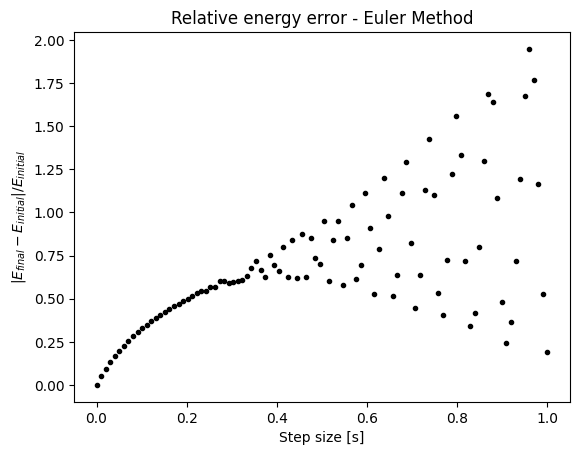

In [ ]:
errors = np.array(errors)
plt.xlabel('Step size [s]')
plt.ylabel('$|E_{final}-E_{initial}|/E_{initial}$')
plt.title('Relative energy error - Euler Method')
plt.scatter(steps[errors<5], errors[errors<5], color='k', marker = '.')
plt.grid()


In [ ]:
steps = np.linspace(0.0001,1,100)
errors = []

for step in steps:
  Y = solve_ivp(two_body_ODE, y0=y0, t_span=(t0, tf), max_step=step, atol=1, rtol=1, args=(GM,))
  errors.append(energy_error(Y.y))


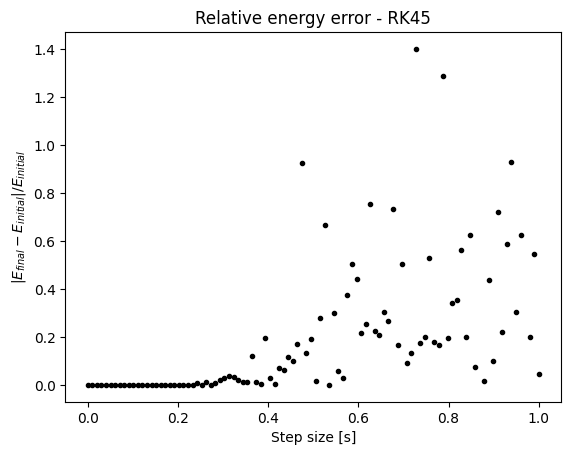

In [ ]:
errors = np.array(errors)
plt.xlabel('Step size [s]')
plt.ylabel('$|E_{final}-E_{initial}|/E_{initial}$')
plt.title('Relative energy error - RK45')
plt.scatter(steps[errors<5], errors[errors<5], color='k', marker = '.')
plt.grid()


In [ ]:
steps = np.logspace(-5.5, -0.5, 100)
errors = []

for step in steps:
  _, y = Euler(two_body_ODE, y0=y0, t_span=(t0, tf), step=step, args=(GM,))
  errors.append(energy_error(y))


In [ ]:
errors = np.array(errors)
plt.xlabel('Step size [s]')
plt.xscale('log')
plt.ylabel('$|E_{final}-E_{initial}|/E_{initial}$')
plt.yscale('log')
plt.title('Relative energy error - Euler')
plt.grid()
plt.scatter(steps[errors<5], errors[errors<5], color='k', marker = '.')


NameError: name 'np' is not defined